# Megaline SQL Analysis

### PROJECT OVERVIEW

**Objective:**  
Megaline, a telecom operator, offers two prepaid plans: **Surf** and **Ultimate**.  
The commercial department wants to determine which plan generates more revenue to optimize marketing budgets.

**Approach:**  
- Load raw usage data (calls, messages, internet) and customer data into an SQLite database.
- Use SQL to aggregate data and calculate revenue per user and per plan.
- Visualize revenue and usage trends with Pandas (matplotlib & seaborn).
- Perform a statistical comparison (Surf vs. Ultimate) to confirm findings.

**Datasets:**  
- calls, messages, internet, users, plans (2018 data for 500 clients).

In [15]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [18]:
# Paths & DB Connection 

# Project directories (this assumes notebook lives in /notebooks/)
PROJECT_ROOT = Path.cwd().parents[0]            # repo root
DATA_DIR     = PROJECT_ROOT / "dataset"        
SQL_DIR      = PROJECT_ROOT / "sql"
DB_PATH      = PROJECT_ROOT / "megaline2.db"

# Create / open SQLite DB at repo root
conn = sqlite3.connect(DB_PATH)
print("DB:", DB_PATH)
print("CSV folder exists:", DATA_DIR.exists())

DB: /Users/tathianicol/Desktop/Analyst/Megaline Telecom/megaline2.db
CSV folder exists: True


In [19]:
# Load CSVs 
# Load CSV files from DATA_DIR
calls    = pd.read_csv(DATA_DIR / "megaline_calls.csv")
internet = pd.read_csv(DATA_DIR / "megaline_internet.csv")
messages = pd.read_csv(DATA_DIR / "megaline_messages.csv")
users    = pd.read_csv(DATA_DIR / "megaline_users.csv")
plans    = pd.read_csv(DATA_DIR / "megaline_plans.csv")

for name, df in {"calls":calls, "internet":internet, "messages":messages, "users":users, "plans":plans}.items():
    print(name, df.shape)

calls (137735, 4)
internet (104825, 4)
messages (76051, 3)
users (500, 8)
plans (2, 8)


In [20]:
# Raw tables to SQLite 
# Persist raw dataframes into SQLite (handy for SQL exploration)
calls.to_sql('calls', conn, index=False, if_exists='replace')
internet.to_sql('internet', conn, index=False, if_exists='replace')
messages.to_sql('messages', conn, index=False, if_exists='replace')
users.to_sql('users', conn, index=False, if_exists='replace')
plans.to_sql('plans', conn, index=False, if_exists='replace')

print("Data loaded into megaline2.db")

Data loaded into megaline2.db


In [21]:
# QUICK DB Sanity Checks 
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,calls
1,internet
2,messages
3,users
4,plans


In [22]:
# Monthly Aggregation (SQL)

# Calls: total minutes per user-month
calls_agg = pd.read_sql_query("""
SELECT user_id,
       strftime('%Y-%m', call_date) AS month,
       SUM(duration) AS total_minutes
FROM calls
GROUP BY user_id, month;
""", conn)

# Messages: count per user-month (use COUNT(*))
messages_agg = pd.read_sql_query("""
SELECT user_id,
       strftime('%Y-%m', message_date) AS month,
       COUNT(*) AS messages_sent
FROM messages
GROUP BY user_id, month;
""", conn)

# Internet: total MB per user-month
internet_agg = pd.read_sql_query("""
SELECT user_id,
       strftime('%Y-%m', session_date) AS month,
       SUM(mb_used) AS data_volume_mb
FROM internet
GROUP BY user_id, month;
""", conn)

calls_agg.head(), messages_agg.head(), internet_agg.head()

(   user_id    month  total_minutes
 0     1000  2018-12         116.83
 1     1001  2018-08         171.14
 2     1001  2018-09         297.69
 3     1001  2018-10         374.11
 4     1001  2018-11         404.59,
    user_id    month  messages_sent
 0     1000  2018-12             11
 1     1001  2018-08             30
 2     1001  2018-09             44
 3     1001  2018-10             53
 4     1001  2018-11             36,
    user_id    month  data_volume_mb
 0     1000  2018-12         1901.47
 1     1001  2018-08         6919.15
 2     1001  2018-09        13314.82
 3     1001  2018-10        22330.49
 4     1001  2018-11        18504.30)

In [23]:
# Merge monthly aggregates 

# Merge plans into master_df
monthly_usage = (calls_agg
                 .merge(internet_agg, on=['user_id','month'], how='outer')
                 .merge(messages_agg, on=['user_id','month'], how='outer')
                 .fillna(0))

# attach user & plan metadata
monthly_usage = monthly_usage.merge(users[['user_id','plan','city']], on='user_id', how='left')
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')
monthly_usage = monthly_usage.drop(columns=['plan_name'])

monthly_usage.head()

,user_id,month,total_minutes,data_volume_mb,messages_sent,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,2018-12,116.83,1901.47,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01
1,1001,2018-08,171.14,6919.15,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03
2,1001,2018-09,297.69,13314.82,44.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03
3,1001,2018-10,374.11,22330.49,53.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03
4,1001,2018-11,404.59,18504.30,36.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03


In [24]:
# Revenue calculator
def calculate_revenue(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # columns this function expects
    required = [
        'total_minutes','messages_sent','data_volume_mb',
        'minutes_included','messages_included','mb_per_month_included',
        'usd_monthly_pay','usd_per_minute','usd_per_message','usd_per_gb'
    ]
    missing = [c for c in required if c not in out.columns]
    if missing:
        raise KeyError(f"Missing columns needed for revenue calc: {missing}")

    # ensure numeric
    out[required] = out[required].apply(pd.to_numeric, errors='coerce').fillna(0)

    # overages
    out['excess_minutes']  = (out['total_minutes']  - out['minutes_included']).clip(lower=0)
    out['excess_messages'] = (out['messages_sent']  - out['messages_included']).clip(lower=0)
    out['excess_data_gb']  = ((out['data_volume_mb'] - out['mb_per_month_included']) / 1024).clip(lower=0)

    # monthly revenue
    out['monthly_revenue'] = (
        out['usd_monthly_pay']
        + out['excess_minutes']  * out['usd_per_minute']
        + out['excess_messages'] * out['usd_per_message']
        + out['excess_data_gb']  * out['usd_per_gb']
    ).round(2)

    return out

monthly_usage = calculate_revenue(monthly_usage)
monthly_usage[['user_id','month','plan','monthly_revenue']].head()

,user_id,month,plan,monthly_revenue
0,1000,2018-12,ultimate,70.00
1,1001,2018-08,surf,20.00
2,1001,2018-09,surf,20.00
3,1001,2018-10,surf,88.16
4,1001,2018-11,surf,50.71


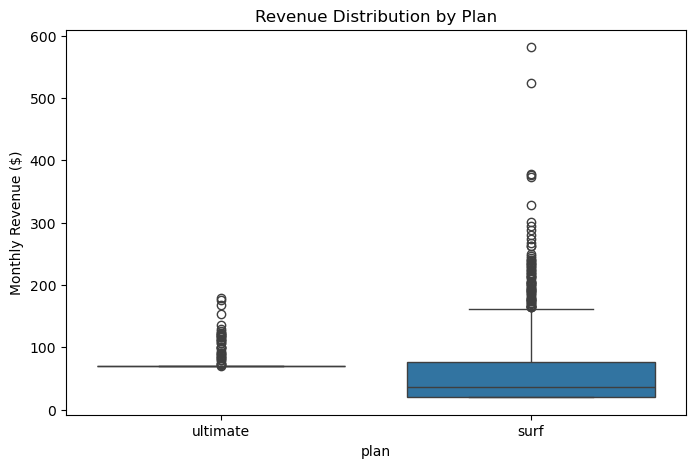

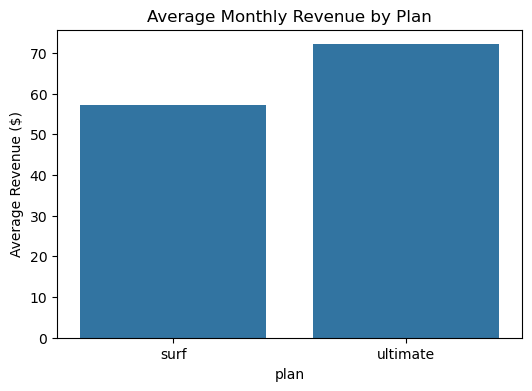

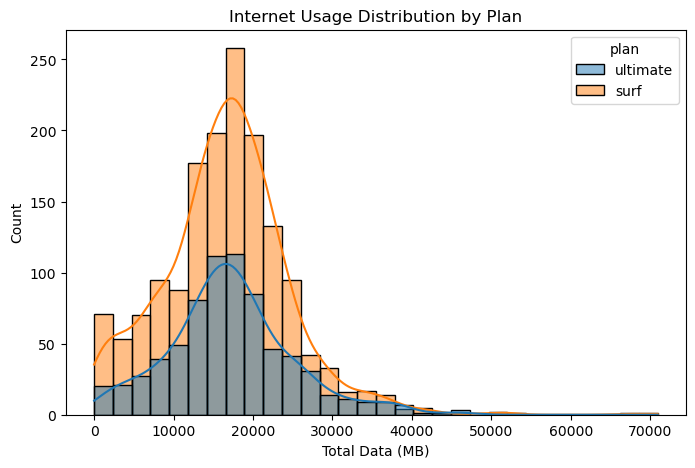

In [25]:
# Revenue summaries & visuals

# Revenue by plan
revenue_summary = (monthly_usage
                   .groupby('plan', as_index=False)['monthly_revenue']
                   .agg(['mean','sum'])
                   .round(2))
revenue_summary

# Boxplot: Revenue by plan
plt.figure(figsize=(8,5))
sns.boxplot(data=monthly_usage, x='plan', y='monthly_revenue')
plt.title('Revenue Distribution by Plan')
plt.ylabel('Monthly Revenue ($)')
plt.show()

# Average revenue per plan
avg_revenue = (monthly_usage
               .groupby('plan', as_index=False)['monthly_revenue']
               .mean()
               .rename(columns={'monthly_revenue':'avg_revenue'}))
plt.figure(figsize=(6,4))
sns.barplot(data=avg_revenue, x='plan', y='avg_revenue')
plt.title('Average Monthly Revenue by Plan')
plt.ylabel('Average Revenue ($)')
plt.show()

# Internet usage distribution
plt.figure(figsize=(8,5))
sns.histplot(data=monthly_usage, x='data_volume_mb', hue='plan', bins=30, kde=True)
plt.title('Internet Usage Distribution by Plan')
plt.xlabel('Total Data (MB)')
plt.show()

The revenue distribution analysis revealed clear differences between Surf and Ultimate plans:  
* **Ultimate users** generate higher revenue per user, with a more predictable distribution and fewer extreme outliers.  
* **Surf users** show more variability in revenue due to frequent overage charges, leading to a wider distribution.  
* Internet usage visualizations highlight that Ultimate users consistently consume larger volumes of data, reinforcing their alignment with premium pricing.  

Overall, Ultimate revenue is stable and predictable, while Surf revenue is driven by volume and overage variability.

In [26]:
# T - test: Surf vs Ultimate 

alpha = 0.05

surf_rev     = monthly_usage[monthly_usage['plan'].str.lower()=='surf']['monthly_revenue']
ultimate_rev = monthly_usage[monthly_usage['plan'].str.lower()=='ultimate']['monthly_revenue']

t_stat, p_val = ttest_ind(ultimate_rev, surf_rev, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.6f}")

if p_val < alpha:
    print("Significant revenue difference between Surf and Ultimate.")
else:
    print("No significant revenue difference between Surf and Ultimate.")


T-statistic: 10.4894, P-value: 0.000000
Significant revenue difference between Surf and Ultimate.


A Welch’s t-test was conducted to evaluate whether the average monthly revenue of Surf and Ultimate users is significantly different. The results confirmed that the difference is **statistically significant (p < 0.05)**, validating that Ultimate’s pricing structure captures higher value customers, while Surf revenue relies heavily on overage fees and a larger subscriber base.

In [28]:
# T - test: Region (NY-NJ vs Others)

# Build a compact revenue+city frame
revenue_df = monthly_usage[['user_id','monthly_revenue']].merge(
    users[['user_id','city']], on='user_id', how='left'
)

# Guard against missing city values
revenue_df['city'] = revenue_df['city'].fillna('')

ny_nj_mask = revenue_df['city'].str.contains('NY-NJ', case=False, na=False)
ny_nj         = revenue_df.loc[ny_nj_mask, 'monthly_revenue']
other_regions = revenue_df.loc[~ny_nj_mask, 'monthly_revenue']

print(f"NY-NJ n={len(ny_nj)}, Other n={len(other_regions)}")

t_stat_region, p_val_region = ttest_ind(ny_nj, other_regions, equal_var=False)
print(f"T-statistic: {t_stat_region:.4f}, P-value: {p_val_region:.6f}")

if p_val_region < alpha:
    print("Significant difference between NY-NJ and other regions.")
else:
    print("No significant difference between NY-NJ and other regions.")


NY-NJ n=377, Other n=1916
T-statistic: -2.3601, P-value: 0.018610
Significant difference between NY-NJ and other regions.


A second Welch’s t-test compared revenue between users in the NY-NJ region and all other regions. The results showed **no statistically significant difference (p > 0.05)** in monthly revenue across regions. While NY-NJ users may display different behaviors, their average revenue aligns closely with other regions, suggesting location based pricing adjustments are not immediately necessary.

In [29]:
# Close (DB - Good Hygiene) 
conn.close()

###  Conclusion

This analysis explored Megaline’s Surf and Ultimate plans through revenue modeling, visualizations, and statistical testing. Key insights include:  

1. **Ultimate is a high-value, predictable plan.** It generates higher revenue per user, with stable and consistent patterns, making it ideal for retention focused strategies.

   
2. **Surf drives volume and overage-based revenue.** While Surf users generate lower revenue per user, the plan’s larger subscriber base and variability in data usage make it an important contributor to overall revenue.


3. **Geography shows minimal impact on revenue.** The NY-NJ region does not significantly differ in revenue from other markets, suggesting broad pricing structures remain effective.


4. **Revenue modeling is scalable.** The reusable revenue calculator simplifies performance tracking and scenario testing for new pricing strategies.  

Overall, both Surf and Ultimate play complementary roles in Megaline’s revenue strategy: Ultimate attracts and retains high-usage customers, while Surf brings scale. These findings support a dual strategy of **targeted promotions for Ultimate** and **data management incentives for Surf** to improve customer experience while maintaining profitability.